# Think Bayes: Chapter 7

This notebook presents code and exercises from Think Bayes, second edition.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np

import os, sys

sys.path.insert(1, os.path.join(sys.path[0], '..'))
from thinkbayes2 import Pmf, Cdf, Suite, Joint
import thinkplot

## Warm-up exercises

**Exercise:** Suppose that goal scoring in hockey is well modeled by a 
Poisson process, and that the long-run goal-scoring rate of the
Boston Bruins against the Vancouver Canucks is 2.9 goals per game.
In their next game, what is the probability
that the Bruins score exactly 3 goals?  Plot the PMF of `k`, the number
of goals they score in a game.

**Solution**

Since $\lambda$ is well defined here as 2.9, we can simply model this as a Poisson Pmf.

In [2]:
from thinkbayes2 import MakePoissonPmf

In [3]:
bruins = MakePoissonPmf(lam=2.9, high=10)

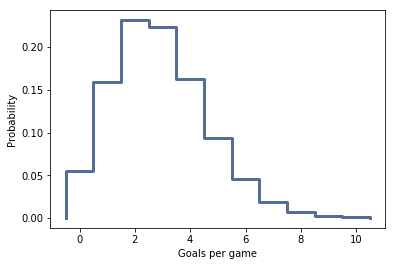

In [4]:
thinkplot.Pmf(bruins)
thinkplot.Config(xlabel='Goals per game',
                ylabel='Probability')

Calculating the probability of 3 goals,

In [5]:
bruins.Prob(3)

0.22370948147445013

**Exercise:**  Assuming again that the goal scoring rate is 2.9, what is the probability of scoring a total of 9 goals in three games?  Answer this question two ways:

1.  Compute the distribution of goals scored in one game and then add it to itself twice to find the distribution of goals scored in 3 games.

2.  Use the Poisson PMF with parameter $\lambda t$, where $\lambda$ is the rate in goals per game and $t$ is the duration in games.

** Solution 1: Adding distributions** 

In [6]:
bruins = MakePoissonPmf(lam=2.9, high=10)

In [7]:
bruins_in_3_games = bruins + bruins + bruins

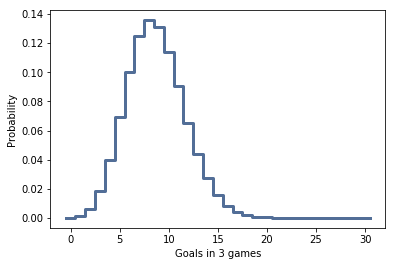

In [8]:
thinkplot.Pmf(bruins_in_3_games)
thinkplot.Config(xlabel='Goals in 3 games',
                ylabel='Probability')

In [9]:
bruins_in_3_games.Prob(9)

0.13117020107678168

** Solution 2 **

So now, I want a single distribution which represents the number of goals in 3 games.

If the Bruins score 2.9 goals per game, then they should on average score $3 \times 2.9$ goals in 3 games.

In [10]:
bruins_in_3_games = MakePoissonPmf(lam=3*2.9, high=30)

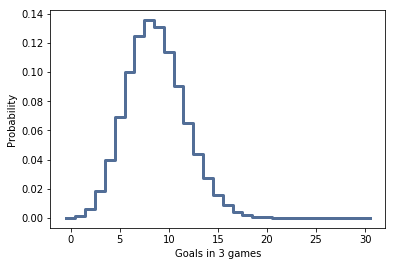

In [11]:
thinkplot.Pmf(bruins_in_3_games)
thinkplot.Config(xlabel='Goals in 3 games',
                ylabel='Probability')

In [12]:
bruins_in_3_games.Prob(9)

0.13108356669746379

Yielding a similar (but not identical) solution. I would go with the first solution, as the average $\lambda$ is calculated on a per game basis, and may not translate to 3 games so simply.

**Exercise:** Suppose that the long-run goal-scoring rate of the
Canucks against the Bruins is 2.6 goals per game.  Plot the distribution
of `t`, the time until the Canucks score their first goal.
In their next game, what is the probability that the Canucks score
during the first period (that is, the first third of the game)?

Hint: `thinkbayes2` provides `MakeExponentialPmf` and `EvalExponentialCdf`.

**Solution **

Once again, $\lambda$ is a single value (2.6 now, instead of 2.9).

In [13]:
from thinkbayes2 import MakeExponentialPmf, EvalExponentialCdf

In [14]:
canucks = MakeExponentialPmf(lam=2.6, high=3)

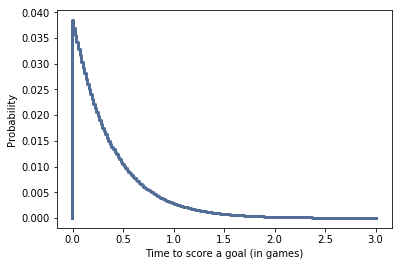

In [15]:
thinkplot.Pmf(canucks)
thinkplot.Config(xlabel='Time to score a goal (in games)',
                ylabel='Probability')

And to find the chance that they will score in the first third of the game

In [16]:
EvalExponentialCdf(lam=2.6, x=0.3)

0.5415939886947765

**Exercise:** Assuming again that the goal scoring rate is 2.8, what is the probability that the Canucks get shut out (that is, don't score for an entire game)?  Answer this question two ways, using the CDF of the exponential distribution and the PMF of the Poisson distribution.

** Solution 1, using the CDF**

In [17]:
1 - EvalExponentialCdf(lam=2.6, x=1)

0.07427357821433389

** Solution 2, using the PMF of the Poisson distribution **

In [18]:
canucks = MakePoissonPmf(lam=2.6, high=10)

In [19]:
canucks.Prob(0)

0.074280019341808556

**Exercise:** In the 2014 FIFA World Cup, Germany played Brazil in a semifinal match. Germany scored after 11 minutes and again at the 23 minute mark. At that point in the match, how many goals would you expect Germany to score after 90 minutes? What was the probability that they would score 5 more goals (as, in fact, they did)?

Note: for this one you will need a new suite that provides a Likelihood function that takes as data the time between goals, rather than the number of goals in a game. 

**Solution**

As with the hockey problem in the book, I need to start by modelling what I believe the $\lambda$ constant will be for this game, since the exponential distribution will depend on this.

`TODO: find lambda from world cup data`

For now, from [this statistics website](https://www.statista.com/statistics/269031/goals-scored-per-game-at-the-fifa-world-cup-since-1930/), I get a $\lambda$ of 2.7; since this is similar to the stats for hockey, lets assume a standard deviation of 0.3 as well.

In [20]:
import scipy
from thinkbayes2 import EvalExponentialPdf

In [21]:
def MakeGaussianPmf(mu, sigma, num_sigmas, n=101):
    pmf = Pmf()
    low = mu - num_sigmas*sigma
    high = mu + num_sigmas*sigma
    for x in np.linspace(low, high, n):
        p = scipy.stats.norm.pdf(x, mu, sigma)
        pmf.Set(x, p)
    pmf.Normalize()
    return pmf

In [22]:
class football_lam(Suite):
    
    def __init__(self):
        pmf = MakeGaussianPmf(2.7, 0.3, 4)
        Suite.__init__(self, pmf)
        
    def Likelihood(self, data, hypo):
        lam = hypo
        # turn k into a fraction of a match
        k = data / 90
        like = EvalExponentialPdf(x=k, lam=lam)
        return like

In [23]:
germany_lam = football_lam()
germany_lam.UpdateSet([11, 12])

3.6503175904404794

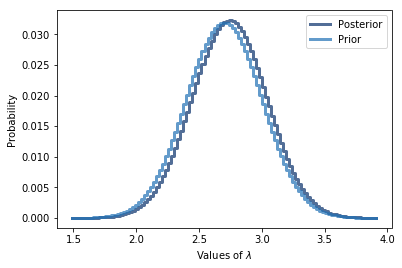

In [24]:
thinkplot.Pmf(germany_lam, label='Posterior')
thinkplot.Pmf(MakeGaussianPmf(2.7, 0.3, 4), label='Prior')
thinkplot.Config(xlabel='Values of $\lambda$', ylabel='Probability')

Now that we have a distribution for $\lambda$, we can use it to predict the probability that they will score 5 more goals in the rest of the game.

In [25]:
from thinkbayes2 import MakeMixture

However, there is a snag; there is only part of the game left. Specifically, there are $90 - 23 = 66$ minutes remaining in the game. As I did in the warmup exercise, I can adjust the $\lambda$ value accordingly to reflect the fact that I am only considering $\frac{66}{90} = 0.73$ of the game.

In [26]:
def make_weighted_poisson_distributions(lambda_distribution, weight):
    poissons = Pmf()
    
    for lam, probability in lambda_distribution.Items():
        poisson = MakePoissonPmf(lam=weight*lam, high=10)
        poissons.Set(poisson, probability)
    mix = MakeMixture(poissons)
    return mix

In [27]:
part_game = make_weighted_poisson_distributions(germany_lam, 66/90)

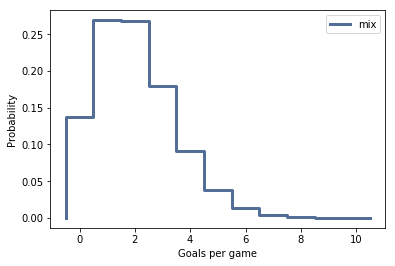

In [28]:
thinkplot.Pmf(part_game)
thinkplot.Config(xlabel='Goals per game', ylabel='Probability')

This allows me to find the how many more goals I expect Germany to score

In [29]:
part_game.Mode()

1

And their chance of scoring 5 goals

In [30]:
part_game.Prob(5)

0.037557996503539519

These seem low, but we only have 2 datapoints with which to update the hypotheses, which means the posterior lambda distribution is very similar to the prior lambda distribution, explaining these results.

**Exercise:** Which is a better way to break a tie: overtime or penalty shots?

**Solution**

Overtime consists of a certain amount of extra time. I'll assume most people would prefer to watch the game being played, instead of penalty shots, but that a tie needs to be broken eventually.

Therefore, if - in the event of a tie - the game will go on for another 30 minutes without a team winning, this indicates penalty shots would have been better. 

Reusing the $\lambda$ from the football stats: 

In [31]:
team1_lam = football_lam()
team2_lam = football_lam()

In [32]:
# Simulating a tie
team1_lam.Update(1)
team2_lam.Update(1)

2.6192479234493895

In [33]:
team1_overtime = make_weighted_poisson_distributions(team1_lam, 30/90)
team2_overtime = make_weighted_poisson_distributions(team2_lam, 30/90)

Now, I want to find the probability that one team will score more goals than the other, which I can do simply by subtracting their distributions

In [34]:
goal_diff = team1_overtime - team2_overtime

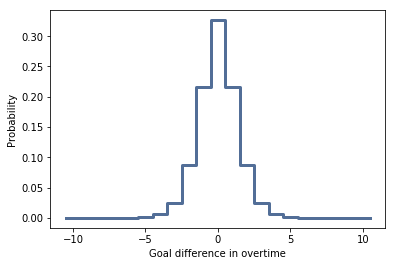

In [35]:
thinkplot.Pmf(goal_diff)
thinkplot.Config(xlabel='Goal difference in overtime', ylabel='Probability')

And now, find the probability that the goal difference is not 0

In [36]:
1 - goal_diff.Prob(0)

0.67369784867444138

So there's a 67 % chance of a tie-breaker in overtime; this seems like the more entertaining way to go!

Of course, I can also do this for a different number of tied goals.

In [37]:
def PenaltyOrOvertime(num_goals):
    team1_lam = football_lam()
    team2_lam = football_lam()
    
    # Simulating a tie
    team1_lam.Update(num_goals)
    team2_lam.Update(num_goals)
    
    team1_overtime = make_weighted_poisson_distributions(team1_lam, 30/90)
    team2_overtime = make_weighted_poisson_distributions(team2_lam, 30/90)
    
    goal_diff = team1_overtime - team2_overtime
    
    return (1 - goal_diff.Prob(0))

In [38]:
PenaltyOrOvertime(2)

0.67362576423609943

In [39]:
PenaltyOrOvertime(3)

0.67355363689454784

So it seems that the outcome of overtime remains relatively stable as the number of goals changes

In [40]:
PenaltyOrOvertime(10)

0.67304754205255568

**Exercise:** Suppose that you are an ecologist sampling the insect population in a new environment. You deploy 100 traps in a test area and come back the next day to check on them. You find that 37 traps have been triggered, trapping an insect inside. Once a trap triggers, it cannot trap another insect until it has been reset.
If you reset the traps and come back in two days, how many traps do you expect to find triggered? Compute a posterior predictive distribution for the number of traps.

** Solution **

I can model the triggering of traps as a Poisson process. I need to predict a value for $\lambda$, and then update this estimate based on what has been observed. Here, my value for $\lambda$ is the number of traps which will be triggered - on average - within the one day period.

Since I have no idea how many insects are in the area to begin with - and their propensity for being trapped - I'll start with a uniform prior for $\lambda$.

In [46]:
from thinkbayes2 import MakeUniformPmf, EvalPoissonPmf

In [51]:
class InsectLam(Suite):
    
        
    def __init__(self):
        pmf = MakeUniformPmf(low=0, high=100, n=101)
        Suite.__init__(self, pmf)
        
    def Likelihood(self, data, hypo):
        lam = hypo
        like = EvalPoissonPmf(k=data, lam=lam)
        return like

In [52]:
insect_lam = InsectLam()
insect_lam.Update(37)

0.0099009900990071516

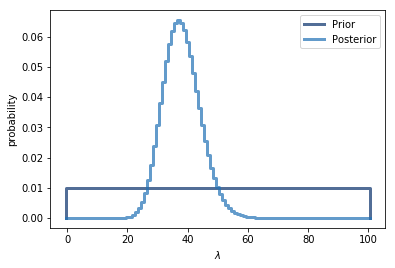

In [54]:
thinkplot.Pmf(MakeUniformPmf(low=0, high=100, n=101), label='Prior')
thinkplot.Pmf(insect_lam, label='Posterior')
thinkplot.Config(xlabel='$\lambda$', ylabel='probability')

Next, I can use this distribution of lambda to make a mixture of likely outcomes. Note, since I'm coming back 2 days later, I can add two distributions for one day together, or multiply $\lambda$ by 2 (as we saw before in the Bruins problem, the result is similar).

In [58]:
def make_poisson_distributions(lambda_distribution):
    poissons = Pmf()
    
    for lam, probability in lambda_distribution.Items():
        poisson = MakePoissonPmf(lam=lam, high=100)
        poissons.Set(poisson, probability)
    mix = MakeMixture(poissons)
    return mix

In [59]:
day1 = make_poisson_distributions(insect_lam)
day2 = make_poisson_distributions(insect_lam)

result = day1 + day2

Note: it's not completely fair to simply add them together, since strictly speaking the $\lambda$ distribution changes for day 2 when less traps are untriggered, but given how much information we have, this seems like a fair approximation.

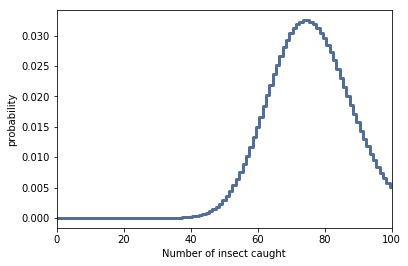

In [62]:
thinkplot.Pmf(result)
thinkplot.Config(xlabel='Number of insect caught', ylabel='probability', xlim=(0,100))